#### Please first take a look to my repository https://github.com/eng-amrahmed/vanilla-gan-tf2
#### You will find there a fully documented code to help you understand How GAN works
#### This will help you to understand the below implementation 



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical

tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [2]:
if not os.path.exists('cgan_samples/'):
    os.makedirs('cgan_samples/')

In [3]:
seed          = 2019
batch_size    = 32
iterations    = 100000
lr            = 1e-4
Z_dim         = 100

In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
(x_train, y_train), (_, _) = datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
y_train_onehot = to_categorical(y_train)

In [6]:
y_dim = y_train_onehot.shape[1]

In [7]:
class Discriminator(tf.keras.layers.Layer):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear_1 = layers.Dense(128)
        self.linear_2 = layers.Dense(1)
            
    def call(self, x, y):
        x = tf.concat([x, y], axis=1) 
        x = self.linear_1(x)
        x = tf.nn.relu(x)
        #x = tf.nn.dropout(x, 0.2)
        x = self.linear_2(x)
        x = tf.nn.sigmoid(x)        
        return x

In [8]:
class Generator(tf.keras.layers.Layer):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear_1 = layers.Dense(128)
        self.linear_2 = layers.Dense(784)
            
    def call(self, z, y):
        x = tf.concat([z, y], axis=1) 
        x = self.linear_1(x)
        x = tf.nn.relu(x)
        #x = tf.nn.dropout(x, 0.2)
        x = self.linear_2(x)
        x = tf.nn.sigmoid(x)        
        return x

In [9]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [10]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [11]:
generator     = Generator()
discriminator = Discriminator()
optimizer = tf.optimizers.Adam(lr)

In [12]:
D_losses = []
G_losses = []

for it in range(iterations):    
   
    if it % 1000 == 0:
        
        Z_sample = sample_Z(16, Z_dim)
        y_sample = np.zeros(shape=[16, y_dim])
        y_sample[:, 7] = 1

        samples = generator(Z_sample, y_sample)
        
        fig = plot(samples.numpy())
        plt.savefig('cgan_samples/{}.png'.format(str(it).zfill(3)), bbox_inches='tight')
        plt.close(fig)
   
   
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    X_mb = x_train[idx]
    y_mb = y_train_onehot[idx]
   
           
    with tf.GradientTape() as tape:  
        Z           = sample_Z(batch_size, Z_dim)
        Fake_sample = generator(Z, y_mb)
        D_real_prob = discriminator(X_mb, y_mb)
        D_fake_prob = discriminator(Fake_sample, y_mb)
        D_loss      = -tf.reduce_mean(tf.math.log(D_real_prob) + tf.math.log(1. - D_fake_prob))

        gradients = tape.gradient(D_loss, discriminator.trainable_weights)
    optimizer.apply_gradients(zip(gradients, discriminator.trainable_weights))

      
    with tf.GradientTape() as tape:        
        Z           = sample_Z(batch_size, Z_dim)
        Fake_sample = generator(Z, y_mb)
        D_fake_prob = discriminator(Fake_sample, y_mb)
        
        G_loss   = -tf.reduce_mean(tf.math.log(D_fake_prob))
                
        gradients = tape.gradient(G_loss, generator.trainable_weights)
    optimizer.apply_gradients(zip(gradients, generator.trainable_weights))
    
    
    if it % 1000 == 0:
        print('Iter: {}     D_loss: {:.4f}     G_loss: {:.4f}'.format(it, D_loss, G_loss))

    
    D_losses.append(D_loss)
    G_losses.append(G_loss)
        

Iter: 0     D_loss: 1.3045     G_loss: 1.0804
Iter: 1000     D_loss: 0.1798     G_loss: 2.9678
Iter: 2000     D_loss: 0.2380     G_loss: 2.2174
Iter: 3000     D_loss: 0.1538     G_loss: 2.3012
Iter: 4000     D_loss: 0.0576     G_loss: 3.0792
Iter: 5000     D_loss: 0.1592     G_loss: 3.9592
Iter: 6000     D_loss: 0.0901     G_loss: 3.7376
Iter: 7000     D_loss: 0.1946     G_loss: 3.5143
Iter: 8000     D_loss: 0.0898     G_loss: 3.5180
Iter: 9000     D_loss: 0.1247     G_loss: 3.5775
Iter: 10000     D_loss: 0.3520     G_loss: 2.5997
Iter: 11000     D_loss: 0.1127     G_loss: 3.5136
Iter: 12000     D_loss: 0.1320     G_loss: 2.6255
Iter: 13000     D_loss: 0.1759     G_loss: 3.3541
Iter: 14000     D_loss: 0.1706     G_loss: 3.3116
Iter: 15000     D_loss: 0.4074     G_loss: 3.4610
Iter: 16000     D_loss: 0.0741     G_loss: 3.5767
Iter: 17000     D_loss: 0.1077     G_loss: 4.0688
Iter: 18000     D_loss: 0.0694     G_loss: 3.7295
Iter: 19000     D_loss: 0.1138     G_loss: 4.1517
Iter: 20000  

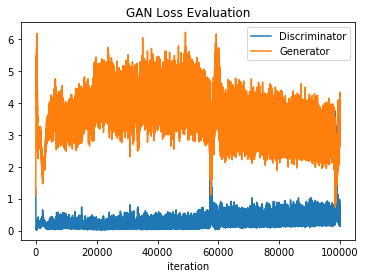

In [13]:
plt.plot(D_losses)
plt.plot(G_losses)
plt.title('GAN Loss Evaluation')
plt.ylabel('')
plt.xlabel('iteration')
plt.legend(['Discriminator', 'Generator'],loc='upper right')
plt.show()

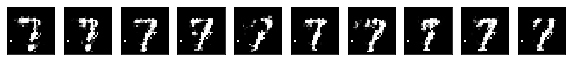

In [14]:
# let's use the generator to sample a particular label
label = 7

n = 10  # number of samples

Z_sample = sample_Z(n, Z_dim)
y_sample = np.zeros(shape=[10, y_dim])
y_sample[:, label] = 1
samples = generator(Z_sample, y_sample)

plt.figure(figsize=(10, 32))
for i in range(1, n+1):
    
    ax = plt.subplot(1, 10, i)
    
    plt.imshow(np.array(samples)[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()    